<a href="https://colab.research.google.com/github/FokaKefir/KepKreator/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# When runnning in colab
#!pip install wandb
#!pip install keras_tuner

# Import dependecies

In [25]:
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, Input, Flatten, Reshape, Embedding, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model
from tensorflow import keras
import keras_tuner

import numpy as np
import matplotlib.pyplot as plt

import wandb
import sys, os

VAL_MODEL_PATH = 'validation_cnn.hdf5' # todo reafactor this (two instances with wandb)
PROJECT = 'KepKreator'

# Preprocess the data

## Load data

In [26]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

## Plot some random examples

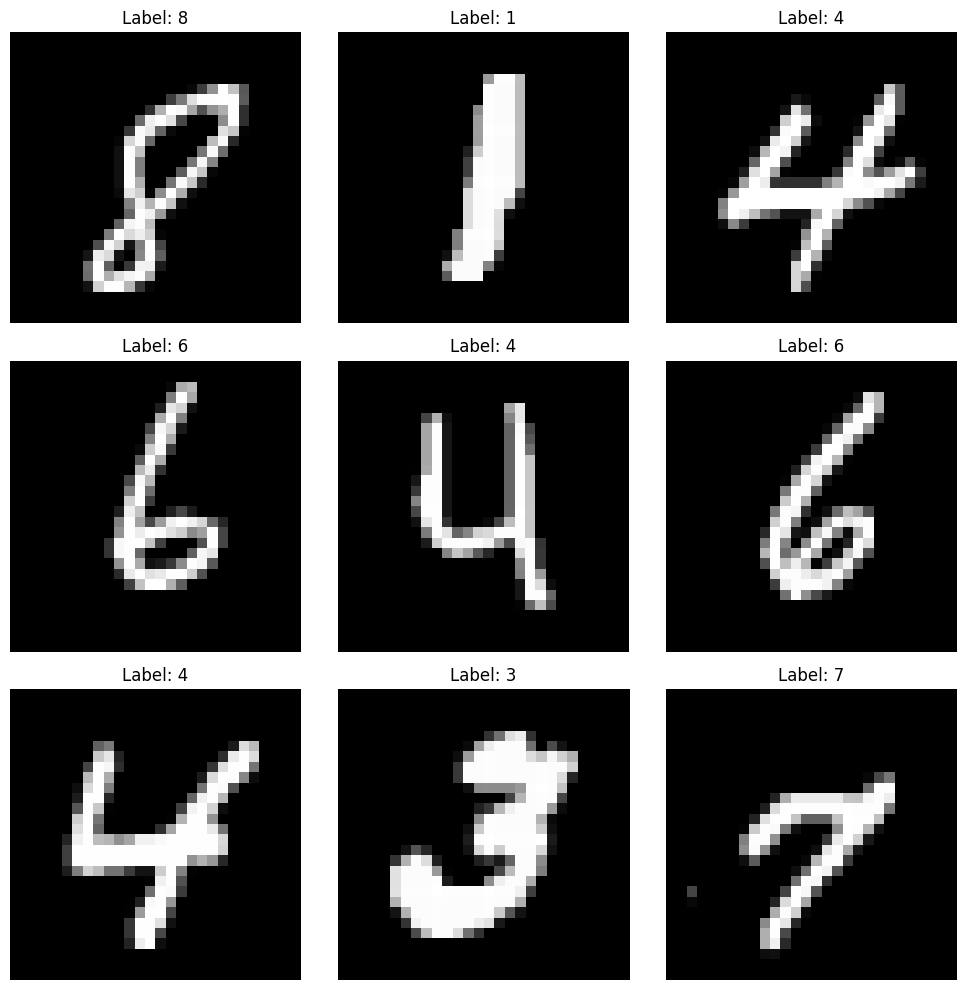

In [27]:
def show_images(examples):
  random_indices = np.random.choice(examples.shape[0], 9, replace=False)

  # rescale images (-1, +1) -> (0, 1)
  examples = 0.5 * examples + 0.5

  plt.figure(figsize=(10, 10))
  for i, index in enumerate(random_indices, 1):
      plt.subplot(3, 3, i)
      plt.imshow(x_train[index], cmap='gray')
      plt.title(f"Label: {labels_train[index]}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

show_images(x_train)

# Evaluation metrics for the generated images

I found the following metrics:

* inception score 
    * [medium article](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a)
    * [short code introduction](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)
* parzen window estimation
* conditional inception scores
    * [Evaluation Metrics for Conditional Image Generation](https://arxiv.org/abs/2004.12361)
* Frechet inception distance
* kernel inception distance
    * [KID code and GAN tips and trics](https://keras.io/examples/generative/gan_ada/#dataefficient-gans-with-adaptive-discriminator-augmentation)

## Conditional inception scores and inception score:

In [28]:
import numpy as np

def kl_divergence(a, b):
   '''Kullback-Leibler divergence
   Smaller value means more similar distributions'''
   a, b = np.atleast_2d(np.asarray(a)), np.atleast_2d(np.asarray(b))
   eps = 1e-16
   Dkls = a * np.log((a + eps) / (b + eps))
   return Dkls.sum(axis=1)

# seperately testable function calculating the metric
def _bcis(y_hat, labels):
    pG_y = np.expand_dims(y_hat.mean(axis=0), 0) # mean for all generated samples of pG_yx
    
    classes = np.unique(labels)
    Dkl = np.ndarray(len(classes))
    for i, cond in enumerate(classes):
        # mean on classes of the pG_yx values
        pG_yc = np.expand_dims(y_hat[labels == cond].mean(axis=0), 0)
        Dkl[i] = kl_divergence(pG_yc, pG_y)[0]
    return np.exp(Dkl.mean())

# pG_yx is the predicted output by the baseline model
def bcis_metric(model, inputs, labels):
    '''Between-class inception score
    Measures how close the representation of classes is to real data.
    Higher BCIS is better, it indicates the distinct class representation
    of the conditioned classes and a wide coverage across the conditional
    classes, which is desired.
    bcis = exp( Ec{ Dkl( pG_yc || pG_y ) } )'''
    inputs, labels = np.asarray(inputs), np.asarray(labels)
    y_hat = model.predict(inputs)
    return _bcis(y_hat, labels)

# seperately testable function calculating the metric
def _wcis(y_hat, labels):
    classes = np.unique(labels)
    Dkl = np.ndarray(len(classes))

    I = np.ndarray(len(classes))
    for i, cond in enumerate(classes):
        # mean of pG_yx with the given condition, as in BCIS
        pG_yc = np.expand_dims(y_hat[labels == cond].mean(axis=0), 0)
        # x is sampled from the given class
        pG_yx = y_hat[labels == cond]
        # kl divergence for each sample within the class
        Dkl = kl_divergence(pG_yx, pG_yc)
        I[i] = Dkl.mean(axis=0)
    return np.exp(I.mean())

def wcis_metric(model, inputs, labels):
    '''Within-class inception score
    Measures the quality and diversity for each of the classes.
    High WCIS indicates a wide coverage of real classes within the 
    conditioned classes, which is an undesired property.
    wcis = exp( Ec{ Dkl( pG_yx || pG_yc ) } )'''
    inputs, labels = np.asarray(inputs), np.asarray(labels)
    y_hat = model.predict(inputs)
    return _wcis(y_hat, labels)

def _inception_score(y_hat):
    p_y = np.expand_dims(y_hat.mean(axis=0), 0)
    # kl divergence for each image
    Dkls = kl_divergence(y_hat, p_y)
    return np.exp(Dkls.mean())

# calculate the inception score for p(y|x)
def inception_score_metric(model, inputs):
    '''Inception score
    IS = exp( Ex{ Dkl( pG_yx || pG_y ) } )'''
    inputs = np.asarray(inputs)
    y_hat = model.predict(inputs)
    return _inception_score(y_hat)

def get_metrics(model, inputs, labels):
    '''Returns inception score, withing class inception score, 
    between class inception score '''
    inputs, labels = np.asarray(inputs), np.asarray(labels)
    y_hat = model.predict(inputs)
    IS = _inception_score(y_hat)
    bcis = _bcis(y_hat, labels)
    wcis = _wcis(y_hat, labels)
    return IS, wcis, bcis


# Define the Model

## Define Discriminator

In [29]:
def build_discriminator(config, in_shape=(28, 28, 1), n_classes=10):

  # label input
  i_label = Input(shape=(1, ))
  x_label = Embedding(n_classes, 50)(i_label)
  x_label = Dense(in_shape[0] * in_shape[1], activation='tanh')(x_label)
  x_label = Reshape((in_shape[0], in_shape[1], 1))(x_label)

  # image input
  i_img = Input(shape=in_shape)

  # concatenate
  x = Concatenate()([x_label, i_img])

  # conv layers
  x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='tanh')(i_img)
  x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')(x)
  x = Flatten()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model([i_img, i_label], x)
  model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(config['discr_learning_rate'],
                     beta_1=config['discr_adam_beta1']),
      metrics=['accuracy']
  )
  return model


## Define Generator

In [30]:
def build_generator(latent_dim, n_classes=10):

  # label input
  i_label = Input(shape=(1, ))
  x_label = Embedding(n_classes, 50)(i_label)
  x_label = Dense(7 * 7 * 28, activation='tanh')(x_label)
  x_label = Reshape((7, 7, 28))(x_label)

  # foundation for 7x7 image
  i_lat = Input(shape=(latent_dim, ))
  x_lat = Dense(100 * 7 * 7, activation='tanh')(i_lat)
  x_lat = Reshape((7, 7, 100))(x_lat)

  # concatenate
  x = Concatenate()([x_lat, x_label])

  # upsample to 14x14
  x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

  # upsample to 28x28
  x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

  # make only one color channel, values in (-1, +1)
  x = Conv2D(1, (7, 7), activation='tanh', padding='same')(x)
  return Model([i_lat, i_label], x)

## Define GAN

In [31]:
def define_gan(generator, discriminator, config):
  # make weights in the discriminator not trainable
  discriminator.trainable = False

  # get noise and label inputs from generator model
  gen_lat, gen_label = generator.input

  # get image output from the generator model
  gen_output = generator.output

  # connect image output and label input from generator as inputs to discriminator
  gan_output = discriminator([gen_output, gen_label])

  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_lat, gen_label], gan_output)

  model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate=config['gan_learning_rate'],
                     beta_1=config['gan_adam_beta1'])
  )
  return model

## Real image sampling

In [32]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.choice(labels.shape[0], n_samples)
  x_imgs = images[ix]
  x_labels = labels[ix]
  y = np.ones((n_samples, 1))
  return [x_imgs, x_labels], y

## Lateint point generator

In [33]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  x_labels = np.random.randint(0, n_classes, n_samples)
  return [x_input, x_labels]

## Fake image generator

In [34]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input, x_labels = generate_latent_points(latent_dim, n_samples)

  # predict outputs
  imgs = generator.predict([x_input, x_labels])

  # create class labels
  y = np.zeros((n_samples, 1))
  return [imgs, x_labels], y

# Train the Model

## Fake image sampling

In [35]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

def sample_images(generator, latent_dim, epoch=0, batch=0, method='show'):
    WANDB_ROWS = 8
    data, _ = generate_fake_samples(generator, latent_dim, 25)
    imgs, labels = data
    rows, cols = 5, 5

    # Rescale images (-1, +1) -> (0, 1)
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols, figsize=(9, 10))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx], cmap='gray')
            axs[i, j].set_title(f'num: {labels[idx]}')
            axs[i, j].axis('off')
            idx += 1

    if method == 'show':
      plt.show()
    elif method == 'save':
      fig.savefig(f'gan_images/sample_e{epoch}_b{batch}.png')
      plt.close()
    elif method == 'wandb':
      columns = ['epoch', 'batch', 'label_num', 'image']
      im_table = wandb.Table(columns=columns)
      for row in range(WANDB_ROWS):
        im_table.add_data(epoch, batch, labels[row], wandb.Image(imgs[row]))
      wandb.log({'generated_examples': im_table})

## Define train function

In [36]:
import wandb

def train_step(generator, discriminator, gan, dataset, config):
  batch_size = config['batch_size']
  half_batch = batch_size // 2
  latent_dim = config['latent_dim']
  # get randomly selected 'real' samples, with labels
  x_real, y_real = generate_real_samples(dataset, half_batch)

  # update discriminator model weights
  d_loss_real, d_acc_real = discriminator.train_on_batch(x_real, y_real)
  # generate 'fake' examples, with labels
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)

  # update discriminator model weights
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(x_fake, y_fake)

  # calculate loss and accuracy
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # prepare points in latent space as input for the generator, with
  x_gan = generate_latent_points(latent_dim, batch_size)

  # create inverted labels for the fake samples
  y_gan = np.ones((batch_size, 1))

  # update the generator via the discriminator's error
  g_loss = gan.train_on_batch(x_gan, y_gan)
  return d_acc, d_loss, g_loss

def train(generator, discriminator, gan, dataset, config):
  batch_size = config['batch_size']
  n_val = config['n_val']
  epochs = config['epochs']
  latent_dim = config['latent_dim']
  bat_per_epo = dataset[0].shape[0] // batch_size
  half_batch = batch_size // 2
  val_model = load_model(config['VAL_MODEL_PATH'])
  # manually enumerate epochs
  for epoch in range(epochs):
    # enumerate batches over the training set
    for b in range(bat_per_epo):

      d_acc, d_loss, g_loss = train_step(generator, discriminator, gan, dataset, config)

      # summarize loss on this batch
      print(f'>{epoch + 1}/{epochs}, {b + 1}/{bat_per_epo}, d_loss={d_loss:.3f}, d_acc={d_acc:.3f} g_loss={g_loss:.3f}')
      wandb.log({'epoch': epoch + 1,
                 'batch': b+1,
                 'd_loss': d_loss,
                 'd_acc': d_acc,
                 'g_loss': g_loss,})

      if (b + 1) % 150 == 0:
        sample_images(generator, latent_dim, epoch + 1, b + 1, method='wandb')
        # if validaiton required
        # generate images
        (x_fake, y_fake), _ = generate_fake_samples(generator, latent_dim, n_val)
        # calculate metrics on them
        IS, wcis, bcis = get_metrics(val_model, x_fake, y_fake)
        print(f'>{epoch+1/epochs}, {b + 1}/{bat_per_epo}, {bcis=}, {wcis=}, {IS=}')
        wandb.log({'bcis': bcis,
                   'wcis': wcis,
                   'inception_score': IS})

    generator.save(f'generator_{epoch + 1}.h5')

# Create models and train

In [37]:
import wandb
config = {'latent_dim': 100,
          'epochs': 1,
          'batch_size': 100,
          'n_val': 1024,
          'VAL_MODEL_PATH': 'validation_cnn.hdf5',
          'gan_learning_rate': 0.0002,
          'gan_adam_beta1': 0.5,
          'discr_learning_rate': 0.0002,
          'discr_adam_beta1': 0.5,
          }
wandb.init(project='KepKreator', config=config, mode='disabled')
# size of the latent space
latent_dim = wandb.config['latent_dim']

# create the discriminator
discriminator = build_discriminator(wandb.config)

# create the generator
generator = build_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator, wandb.config)

# # train
# train(
#     generator,
#     discriminator,
#     gan,
#     (x_train, labels_train),
#     wandb.config
# )
wandb.finish()

# Hypermodel for hiperparameter optimization

Sources:

* [keras documentation for hyperparameter tuning with custom training loop](https://keras.io/guides/keras_tuner/custom_tuner/)
* [kaggle notebook baout using keras-tuner with wandb](https://www.kaggle.com/code/aritrag/keras-tuner-with-wandb/notebook)
* [keras documentation for keras-tuner Tuners](https://keras.io/guides/keras_tuner/getting_started/#tune-endtoend-workflows)

In [39]:
def hp_to_config(hp):
    keys = ['latent_dim', 'epochs', 'batch_size', 'n_val', 'VAL_MODEL_PATH',
            'gan_learning_rate', 'gan_adam_beta1', 'discr_learning_rate', 
            'discr_adam_beta1']
    config = {key: hp.get(key) for key in keys}
    return config

def build_hypermodels(hp):
    config = {'latent_dim': hp.Int('latent_dim', min_value=64, max_value = 256, step = 64),
        'epochs': hp.Fixed('epochs', 1),
        'batch_size': hp.Fixed('batch_size', 100),
        'n_val': hp.Fixed('n_val', 1024),
        'VAL_MODEL_PATH': hp.Fixed('VAL_MODEL_PATH', 'validation_cnn.hdf5'),
        'gan_learning_rate': hp.Fixed('gan_learning_rate', 0.0002),
        'gan_adam_beta1': hp.Fixed('gan_adam_beta1', 0.5),
        'discr_learning_rate': hp.Fixed('discr_learning_rate', 0.0002),
        'discr_adam_beta1': hp.Fixed('discr_adam_beta1', 0.5),
        }
    discriminator = build_discriminator(config)
    generator = build_generator(config['latent_dim'])
    gan = define_gan(generator, discriminator, config)
    return discriminator, generator, gan

class MyTuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, dataset, *args, **kwargs):
        # Get the hp from trial.
        hp = trial.hyperparameters
        discriminator, generator, gan = build_hypermodels(hp)
        config = hp_to_config(hp)
        val_model = load_model(config['VAL_MODEL_PATH'])
        bat_per_epo = dataset[0].shape[0] // config['batch_size']
        log_batch = bat_per_epo // 8
        eval_batch = bat_per_epo // 3
        d_acc, d_loss, g_loss = 0, 0, 0
        EPOCHS = 3

        wcis_list = []
        run = wandb.init(project=PROJECT, config=hp.values)
        for epoch in range(EPOCHS):
            for batch in range(bat_per_epo):
                da, dl, gl = train_step(generator, discriminator, gan, dataset, config)
                d_acc += da
                d_loss += dl
                g_loss += gl
                if batch % log_batch == 0:
                    d_acc, d_loss, g_loss = d_acc / log_batch, d_loss / log_batch, g_loss / log_batch
                    print(f'>{epoch + 1}/{EPOCHS}, {batch + 1}/{bat_per_epo}, '
                          f'd_loss={d_loss:.3f}, d_acc={d_acc:.3f} g_loss={g_loss:.3f}')
                    wandb.log({'epoch': epoch + 1,
                                'batch': batch + 1,
                                'd_loss': d_loss,
                                'd_acc': d_acc,
                                'g_loss': g_loss,})
                    d_acc, d_loss, g_loss = 0, 0, 0
                if batch % eval_batch == 0:
                    (x_fake, y_fake), _ = generate_fake_samples(generator, config['latent_dim'], config['n_val'])
                    # calculate metrics on them
                    IS, wcis, bcis = get_metrics(val_model, x_fake, y_fake)
                    wcis_list.append(wcis)
                    print(f'>{epoch + 1}/{EPOCHS}, {batch + 1}/{bat_per_epo}, {bcis=}, {wcis=}, {IS=}')
                    wandb.log({'bcis': bcis,
                            'wcis': wcis,
                            'inception_score': IS})
        # Finish the wandb run
        run.finish()        
        # Return the objective value to minimize.
        return max(wcis_list)


tuner = MyTuner(
    # No hypermodel or objective specified.
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="tune_anything",
)

# No need to pass anything to search()
# unless you use them in run_trial().
tuner.search((x_train, labels_train))
print(tuner.get_best_hyperparameters()[0].values)



Search: Running Trial #1

default configuration



600
Problem at: /tmp/ipykernel_8956/1909289001.py 37 run_trial


KeyboardInterrupt: 

# Load model

In [ ]:
model = load_model('generator_1.h5')
sample_images(model, latent_dim, method='show')

In [ ]:
model = load_model('generator_4.h5')
sample_images(model, latent_dim, method='show')

In [ ]:
model = load_model('generator_7.h5')
sample_images(model, latent_dim, method='show')

In [ ]:
model = load_model('generator_10.h5')
sample_images(model, latent_dim, method='show')

In [ ]:
model = load_model('generator_13.h5')
sample_images(model, latent_dim, method='show')

In [ ]:
model = load_model('generator_16.h5')
sample_images(model, latent_dim, method='show')